In [69]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import morphology, feature
import random

#wr = False
wr = True
iterations = 10

good = 0
wrong = 0
none = 0

n = 58 # digits (max 58)
nn = 12 # numbers (max 12)
plt_m = 6
#plt_n = int(np.ceil(n / plt_m))
plt_n = int(np.ceil((n + 5*nn)/ plt_m))
fsize = (20, 35)
scale_percent = 60
# --------------------------------------
vars = 21
buff_def = np.zeros(vars)
# --------------------------------------
buff_info = [  # step / min / max
    (0.05, 0.75, 1), (0.05, 0, 0.5), (0.05, 0, 0.5), (0.05, 0.75, 1), (0.00001, 0.00001, 0.0001),  # border_1-5
    (1, 70, 95),  # proc_lines_domination
    (1, 1, 10), (5, 20, 50),  # min_sum_lines,min_lines_on_center
    (0.1, 0.5, 1.5), (0.1, 0.5, 1.5),  # lh5,lv5
    (1, 1, 15), (1, 1, 15),  # sq1,sq2

    (1, 1, 5), (2, 10, 250), (5, 30, 250), (5, 30, 250),  # c_param_1-4
    (10, 0, 150), (10, 0, 150),  # c_param_MinMaxRad

    (1, 1, 5), (5, 30, 100),  # l_param_1-2
    (2, 3, 7)  # canny
]

expected = [
    0, 1, 2, 1, 0, 8, 8, 4, 8, 4, 5, 7, 5, 4, 7,
    6, 9, 3, 0, 9, 3, 2, 9, 6, 3, 1, 3, 6,
    0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4,
    5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9
]

expected_2 = [
    [9, 0, 2, 3], # 100
    [8, 6, 4],
    [7, 5, 1],
    [2, 5, 7],
    [6, 1],
    [4, 8, 1, 2, 6],
    [5, 4, 3, 2, 1],
    [1, 7, 9],
    [6, 9],
    [4, 0, 8, 5],
    [3, 1, 5, 2], # 110
    [7, 0],

    [5, 9, 7],
    [4, 2, 0],
    [1, 3, 1, 8],
    [3, 8],
    [6, 8, 7],
    [8, 2, 1, 5],
    [1, 7],
    [2, 4, 5, 9, 3],
    [3, 2, 4]
]


def avg(x):
    return int(sum(x) / len(x))


def permut(n):
    tab1 = list(range(n))
    tab2 = []
    dl = n - 1
    for _ in range(n):
        x = random.randint(0, dl)
        tab2.append(tab1[x])
        tab1[x] = tab1[dl - 1]
        dl -= 1
    return tab2


def read():
    f = open("def_vars.txt", 'r')
    s = f.readline()
    f.close()
    s = s.split(' ')
    return s


def save(tab):
    s1 = read()
    f = open("buffs.txt", 'a')
    f1 = open("def_vars.txt", 'w')

    s = ""
    s1 = ""
    for i in range(vars):
        s += str(tab[i])
        s1 += str(tab[i] + buff_def[i])
        s += " "
        s1 += " "

    s += "\n"
    s1 += "\n"

    f.write(s)
    f1.write(s1)

    f.close()
    f1.close()

In [70]:
def img2digit(img, buff):
    # for i in range(vars):
    #    buff[i]+=buff_def[i]

    [border_1, border_2, border_3, border_4, border_5,
     proc_lines_domination,
     min_sum_lines, min_lines_on_center,
     lh5, lv5,
     sq1, sq2,

     c_param_1,
     c_param_2,
     c_param_3,
     c_param_4,
     c_param_minRad,
     c_param_maxRad,

     l_param_1,
     l_param_2,
     can] = buff_def + buff
    # ---------------------
    sq1 = int(sq1)
    sq2 = int(sq2)
    can = int(can)
    c_param_minRad = int(c_param_minRad)
    c_param_maxRad = int(c_param_maxRad)
    l_param_2 = int(l_param_2)
    # ---------------------

    number = 'none'
    lines_on_center = 0
    circ_avg_x = 0
    circ_avg_y = 0

    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = morphology.erosion(img, morphology.square(sq1))
    img = morphology.dilation(img, morphology.square(sq2))
    dst = cv2.Canny(img, 50, 200, None, can)

    # ----------------------------------------------------------
    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        c_param_1,
        c_param_2,
        param1=c_param_3,
        param2=c_param_4,
        minRadius=c_param_minRad,
        maxRadius=c_param_maxRad
    )
    num_of_circ = 0
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
        circ_avg_x = avg(circles[0, :, 0])
        circ_avg_y = avg(circles[0, :, 1])
        cv2.circle(img, (circ_avg_x, circ_avg_y), 2, (0, 255, 255), 10)
        num_of_circ = len(circles[0, :])

    img[int(height * (1 / 3)), :] = 255
    img[int(height * (2 / 3)), :] = 255
    # ----------------------------------------------------------
    lines_H = 0
    lines_V = 0
    lines_slash = 0
    lines_bslash = 0

    lines = cv2.HoughLines(dst, l_param_1, np.pi / 180, l_param_2)
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            if circ_avg_x != 0:
                if (np.sin(theta) != 0):
                    tmp = int(rho / np.sin(theta) + circ_avg_x * (-(np.cos(theta) / np.sin(theta))))
                    if tmp - (width * height * border_5) <= circ_avg_y <= tmp + (width * height * border_5):
                        lines_on_center += 1

            cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)

            if abs(a) < border_3:
                lines_H += 1
            elif abs(a) > border_4:
                lines_V += 1
            elif border_1 > a > border_2:
                lines_slash += 1
            elif -border_1 < a < -border_2:
                lines_bslash += 1
    # ----------------------------------------------------------
    suma = sum([lines_H, lines_V, lines_slash, lines_bslash])

    if suma >= min_sum_lines:
        if num_of_circ == 0:
            if ((lines_slash) / suma) >= proc_lines_domination:
                number = 2
            elif ((lines_H + lines_slash) / suma) >= proc_lines_domination:
                number = 7
            elif ((lines_V + lines_slash) / suma) >= proc_lines_domination:
                number = 1
            else:
                number = 4
            # print("Photo num ",sub-1,": ",lines_H,lines_V,lines_slash,lines_bslash)
        elif lines_on_center >= min_lines_on_center:
            number = 8
        elif lines_bslash / suma >= proc_lines_domination:
            number = 8
        elif num_of_circ == 1 and ((lh5 * lines_H + lv5 * lines_V) / suma) >= proc_lines_domination and not (
                circ_avg_y < (1 / 3) * height):
            number = 5
    if number == "none":
        if num_of_circ == 1:
            if circ_avg_y < (1 / 3) * height:
                number = 9
            elif (1 / 3) * height < circ_avg_y < (2 / 3) * height:
                number = 0
            else:
                number = 6
        elif num_of_circ == 2:
            number = 3
    return (img, number)

In [71]:
def look4digits(wr, buff, multidigits):
    global good, wrong, none
    pictures = []
    for i in range(n):
        tmp = str(i)
        if (i < 10):
            tmp = '0' + tmp
        pictures.append(tmp)
    for pic in multidigits:
        for part in pic:
            tmp = 'm' + '_' + part[0] + '_' + part[1]
            pictures.append(tmp)

    if wr == 1:
        plt.figure(figsize=fsize)
    sub = 1
    good = 0
    wrong = 0
    none = 0

    for pic in pictures:
        if wr == 1:
            plt.subplot(plt_n, plt_m, sub)
        image = cv2.imread('data/calc_' + pic + '.jpg')
        img, number = img2digit(image, buff)

        tmp = str(sub - 1)
        if (sub - 1 < 10):
            tmp = '0' + tmp

        if pic[0] == 'm':
            try:
                a = int(pic[2:4])
                b = int(pic[5:7])
                nr = expected_2[a][b]

                if number == nr:
                    status = 'ok'
                    good += 1
                elif number == "none":
                    status = 'none'
                    none += 1
                else:
                    status = 'error'
                    wrong += 1
                # if(status!='ok'):
                #print("Photo num ",tmp," [",pic[2:4],"_",pic[5:7],"] is: ",number,"\t expected: ",expected_2[ int(pic[2:4]) ][ int(pic[5:7]) ]," ",status, sep='')

            except IndexError:
                status = 'no such digit in expected array'
                wrong += 1
                print("Photo num",tmp,":",status)
        else:
            if number == expected[sub - 1]:
                status = 'ok'
                good += 1
            elif number == "none":
                status = 'none'
                none += 1
            else:
                status = 'error'
                wrong += 1
            # if(status!='ok'):
            #print("Photo num",tmp,"is: ",number,"\t expected: ",expected[sub-1],status)

        if wr == 1:
            plt.imshow(img)
        sub += 1

    if wr == 1:
        plt.savefig("result.pdf")
        plt.show()

In [72]:
img_size = 600
min_rec_size = 40
output_number = 0

def split(img, cut = 0):
    global output_number
    original_img = img
    ratio = img.shape[0] / img.shape[1]
    width = int(img_size / (ratio ** (1/2)))
    height = int(img_size * (ratio ** (1/2)))

    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = morphology.erosion(img, morphology.square(10))
    img = morphology.dilation(img, morphology.square(3))

    # change to binary
    T, img = cv2.threshold(img, 111, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # ----------------------------------------------------------

    # delete bad contours
    cnt_list = list(contours)
    size = len(cnt_list)

    i = 0
    while i < size:
        x, y, w, h = cv2.boundingRect(cnt_list[i])
        if(x == 0 or y == 0):
            cnt_list.pop(i)
            i -= 1
            size -= 1
        i += 1

    i = 0
    while i < size:
        x, y, w, h = cv2.boundingRect(cnt_list[i])
        if (    w >= min_rec_size
                and h >= min_rec_size
                ):

            j = i + 1
            while j < size:
                x2, y2, w2, h2 = cv2.boundingRect(cnt_list[j])
                if (    x2 <= x
                        and y2 <= y
                        and x2 + w2 >= x + w
                        and y2 + h2 >= y + h ):

                    cnt_list.pop(i)
                    i -= 1
                    size -= 1
                    break

                elif (    x2 >= x
                        and y2 >= y
                        and x2 + w2 <= x + w
                        and y2 + h2 <= y + h ):

                    cnt_list.pop(j)
                    j -= 1
                    size -= 1

                j += 1
        else:
            cnt_list.pop(i)
            i -= 1
            size -= 1
        i += 1

    contours = tuple(cnt_list)

    # ----------------------------------------------------------

    # make images from contours
    cnt_values = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cnt_values.append([x, y, w, h])

    cnt_values.sort()

    i = 0
    return_arr = []
    for cnt in cnt_values:
        x, y, w, h = cnt

        frame = 20  # additional empty space

        yv = original_img.shape[0] / height
        xv = original_img.shape[1] / width

        if cut == 0:
            # cuts from original image
            outimg = original_img[int((y - frame) * yv) : int((y + h + frame) * yv), int((x - frame) * xv) : int((x + w + frame) * xv)]
        elif cut == 1:
            # cuts from changed image
            outimg = img[(y - frame):(y + h + frame), (x - frame):(x + w + frame)]

        output_number_s = str(output_number)
        i_s = str(i)

        if output_number < 10:
            output_number_s = '0' + output_number_s

        if i < 10:
            i_s = '0' + i_s

        name = "calc_m_" + output_number_s + "_" + i_s
        cv2.imwrite(f"data/" + name + ".jpg", outimg)
        return_arr.append([output_number_s, i_s])

        #cv2.rectangle(img, (x, y), (x + w, y + h), (100, 0, 0), 2)
        #cv2.imshow("img", img)
        #cv2.waitKey(0)
        i += 1

    output_number += 1

    return return_arr

# ****************************************************

def split_all():
    pics = []
    for i in range(nn):
        tmp = str(i)
        if (i < 10):
            tmp = '10' + tmp
        else:
            tmp = '1' + tmp
        pics.append(tmp)

    return_arr = []
    for pic in pics:
        image = cv2.imread('data/calc_' + pic + '.jpg')
        img_arr = split(image, 0)
        return_arr.append(img_arr)

    return return_arr

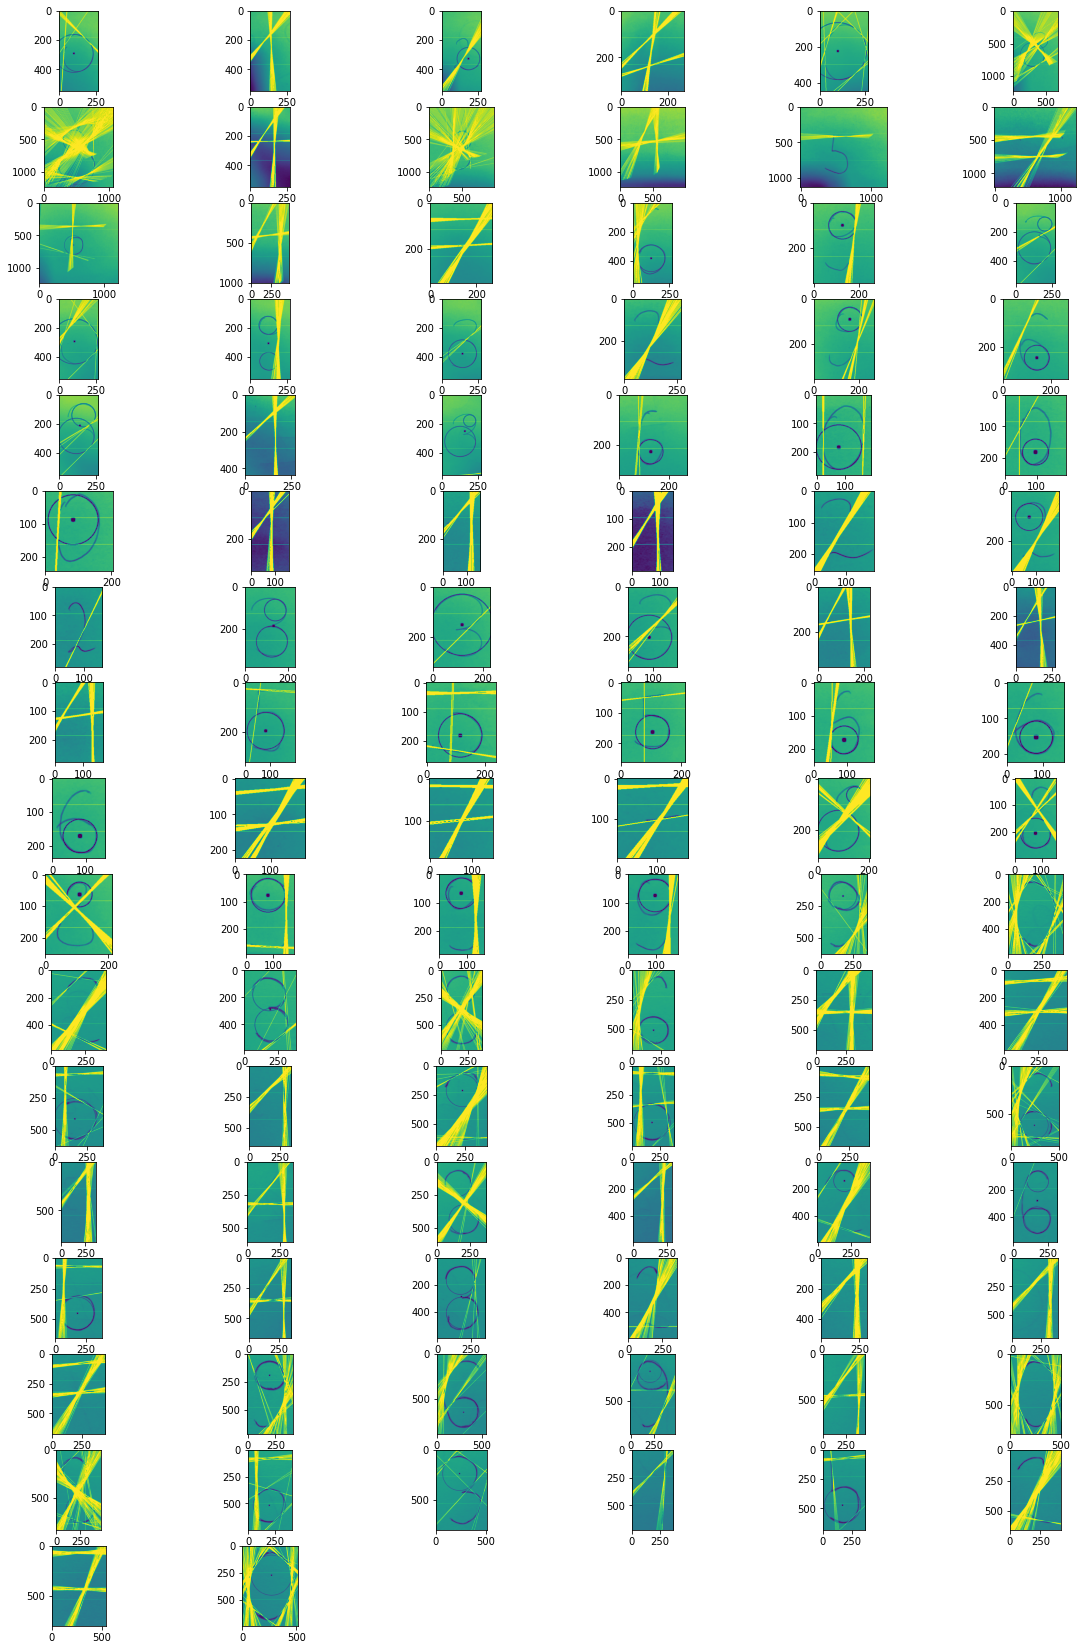

def_good: 80 	def_wrong: 18 	def_none:  0


In [73]:
def main():
    s = read()
    for i in range(vars):
        buff_def[i] = float(s[i])

    buff = np.zeros(vars)
    split_arr = split_all()
    look4digits(wr, buff, split_arr)  # 1 - write

    def_good = good
    def_wrong = wrong
    def_none = none
    global_best = def_good
    print("def_good:", def_good, "\tdef_wrong:", def_wrong, "\tdef_none: ", def_none)

    while (not wr):
        order = permut(vars)
        for _ in range(iterations):
            for j in order:
                best = def_good
                best_state = buff[j]

                interval = buff_info[j][2] - buff_info[j][1]
                steps = int((interval) / buff_info[j][0]) + 1

                for k in range(steps):
                    #print(j,buff[j],buff_info[j][1]+k*buff_info[j][0]-buff_def[j])
                    buff[j] = buff_info[j][1] + k * buff_info[j][0] - buff_def[j]
                    look4digits(wr, buff, split_arr)
                    if good >= best:
                        best_state = buff[j]
                    if good > global_best:
                        global_best = good
                        print("good:", good, "\twrong:", wrong, "\tnone: ", none)
                        print("NICE!\n", buff)
                        save(buff)
                        #print("good:",good,"\twrong:",wrong,"\tnone: ",none,'\t\t',j,buff[j],buff_def[j],k)
                buff[j] = best_state
                #print(buff)
        buff = np.zeros(vars)


if __name__ == '__main__':
    main()